<a href="https://colab.research.google.com/github/BooEazy/Project_DataScience/blob/main/Project/Sesi_Project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
# Untuk Algoritma Clusturing --> KMeans, KMedians, KModes
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [ ]:
# Simple descriptive statistic
# Hanya 2 kolom ini saja yang bisa di cek statistik desktiptif nya
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [ ]:
# Remove anomaly (Anomali di kecualikan atau tidak dipakai)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [ ]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

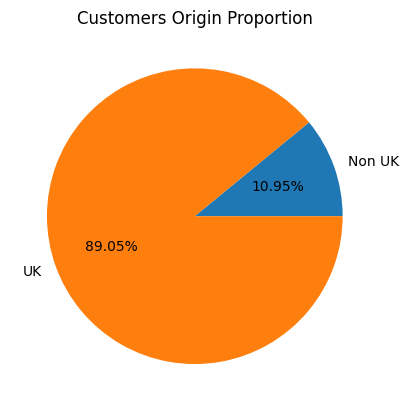

In [ ]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country'] == 'United Kingdom', 'UK', 'Non UK') #Seperti If Else

customers_origin = df.groupby(['Country_isUK']).size()

_ = plt.title('Customers Origin Proportion')
_ = plt.pie(customers_origin, labels = customers_origin.index, autopct = lambda p: f'{p:.2f}%')
plt.show()

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice'] #Pastikan sudah type int atau float
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

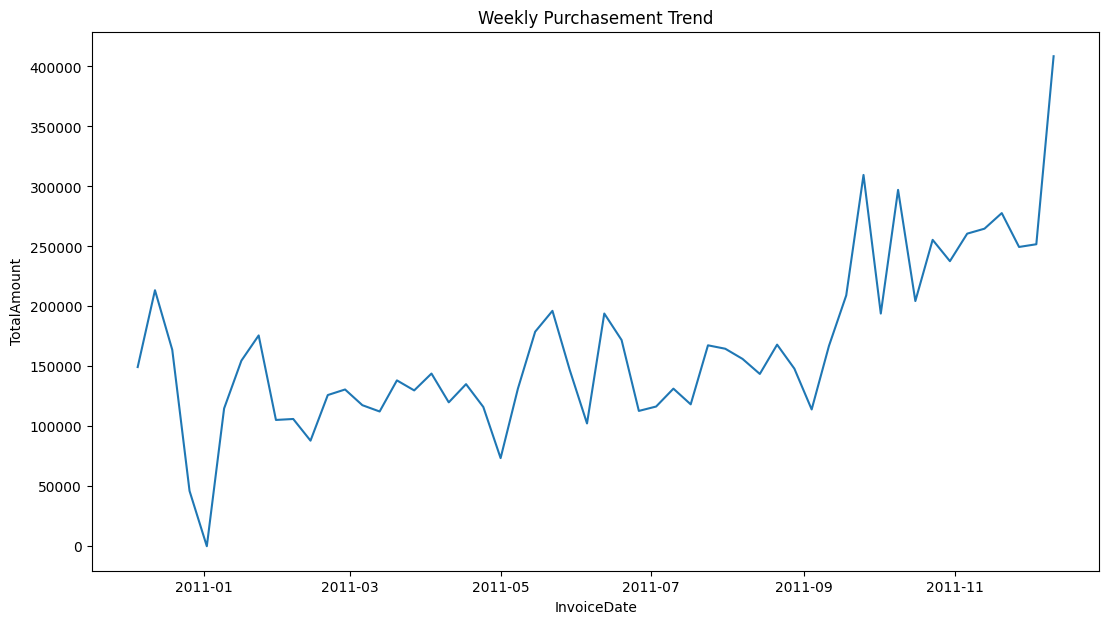

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))
_ = plt.title('Weekly Purchasement Trend')
_ = sns.lineplot(x = weekly_purchasements.index, y = weekly_purchasements)
plt.show()

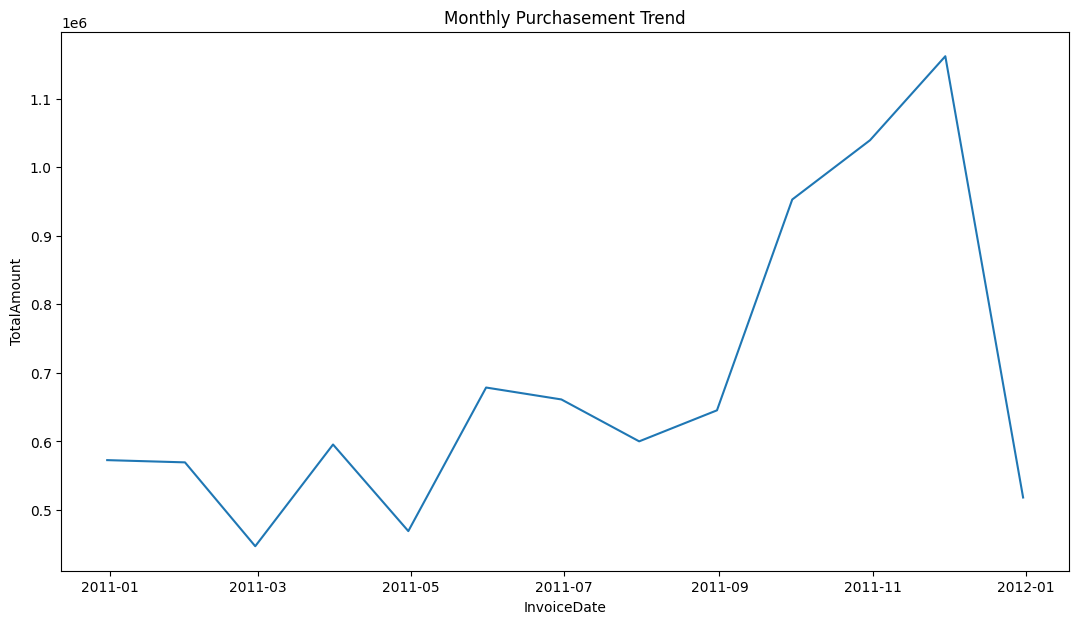

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

_ = plt.figure(figsize=(13, 7))
_ = plt.title('Monthly Purchasement Trend')
_ = sns.lineplot(x = monthly_purchasements.index, y = monthly_purchasements)
plt.show()

## Tugas EDA

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.


In [ ]:
# Mengelompokkan berdasarkan customer dan menghitung total pembelian
customer_purchases = df.groupby('CustomerID')['TotalAmount'].sum()

# Mengambil top 5 customer dengan pembelian terbanyak
top_5_customers = customer_purchases.nlargest(5)

print("Top 5 Customer dengan Pembelian Terbanyak:")
print(top_5_customers)

Top 5 Customer dengan Pembelian Terbanyak:
CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194550.79
16446.0    168472.50
14911.0    143825.06
Name: TotalAmount, dtype: float64


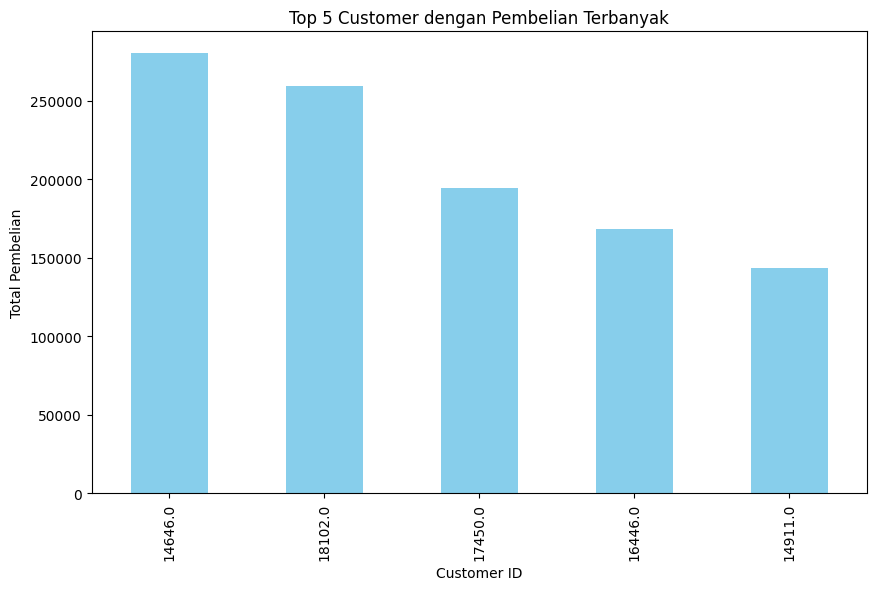

In [ ]:
plt.figure(figsize=(10, 6))
top_5_customers.plot(kind='bar', color='skyblue')
plt.title('Top 5 Customer dengan Pembelian Terbanyak')
plt.xlabel('Customer ID')
plt.ylabel('Total Pembelian')
plt.show()

Note : Kapan waktu pembelian dengan jumlah customer terbanyak?

In [ ]:
# Hitung jumlah pelanggan pada setiap tanggal
daily_customer_counts = df.groupby(by=pd.Grouper(key="InvoiceDate", freq="D"))["CustomerID"].nunique()

# Temukan tanggal dengan jumlah pelanggan terbanyak
max_daily_customer_count = daily_customer_counts.idxmax()

print("Waktu dengan Jumlah Pelanggan Terbanyak:")
print("Tanggal:", max_daily_customer_count)

Waktu dengan Jumlah Pelanggan Terbanyak:
Tanggal: 2011-11-17 00:00:00


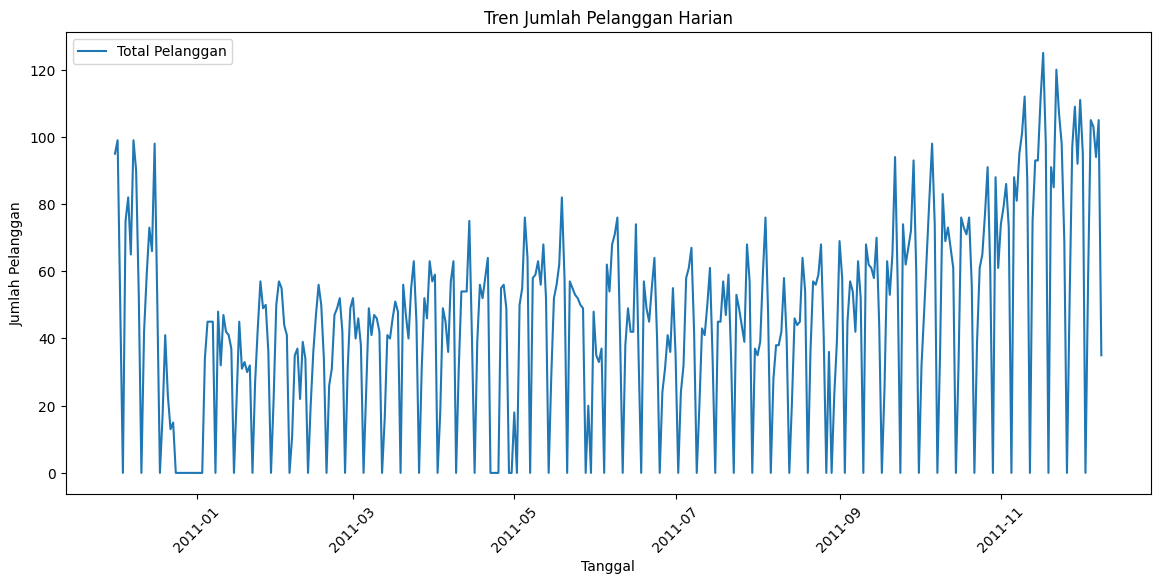

In [ ]:
# Grafik jumlah pelanggan harian
plt.figure(figsize=(14, 6))
sns.lineplot(x=daily_customer_counts.index, y=daily_customer_counts, label='Total Pelanggan')
plt.title('Tren Jumlah Pelanggan Harian')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Note :Apakah ada pola pembelian yang berbeda di hari kerja dibandingkan dengan akhir pekan?

In [ ]:
# Menambahkan kolom "DayType" yang menandai apakah suatu tanggal adalah hari kerja atau akhir pekan
df['DayType'] = df['InvoiceDate'].dt.day_name()
df['DayType'] = df['DayType'].apply(lambda x: 'Weekday' if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'Weekend')

# Memeriksa nilai unik pada kolom "DayType"
print("Nilai Unik pada Kolom DayType:", df['DayType'].unique())

# Hitung jumlah pelanggan pada setiap tanggal dan kategori hari (Weekday/Weekend)
daily_customer_counts = df.groupby(['InvoiceDate', 'DayType'])['CustomerID'].nunique().reset_index()

# Mencari tanggal dengan jumlah pelanggan terbanyak di hari kerja
max_weekday_customer_count = daily_customer_counts.loc[daily_customer_counts['DayType'] == 'Weekday', 'CustomerID'].idxmax()
max_weekday_customer_date = daily_customer_counts.loc[max_weekday_customer_count, 'InvoiceDate']

# Mencari tanggal dengan jumlah pelanggan terbanyak di akhir pekan
max_weekend_customer_count = daily_customer_counts.loc[daily_customer_counts['DayType'] == 'Weekend', 'CustomerID'].idxmax()
max_weekend_customer_date = daily_customer_counts.loc[max_weekend_customer_count, 'InvoiceDate']

print("Waktu dengan Jumlah Pelanggan Terbanyak di Hari Kerja:")
print("Tanggal:", max_weekday_customer_date)

print("\nWaktu dengan Jumlah Pelanggan Terbanyak di Akhir Pekan:")
print("Tanggal:", max_weekend_customer_date)

Nilai Unik pada Kolom DayType: ['Weekday' 'Weekend']
Waktu dengan Jumlah Pelanggan Terbanyak di Hari Kerja:
Tanggal: 2010-12-06 12:23:00

Waktu dengan Jumlah Pelanggan Terbanyak di Akhir Pekan:
Tanggal: 2011-05-08 15:22:00


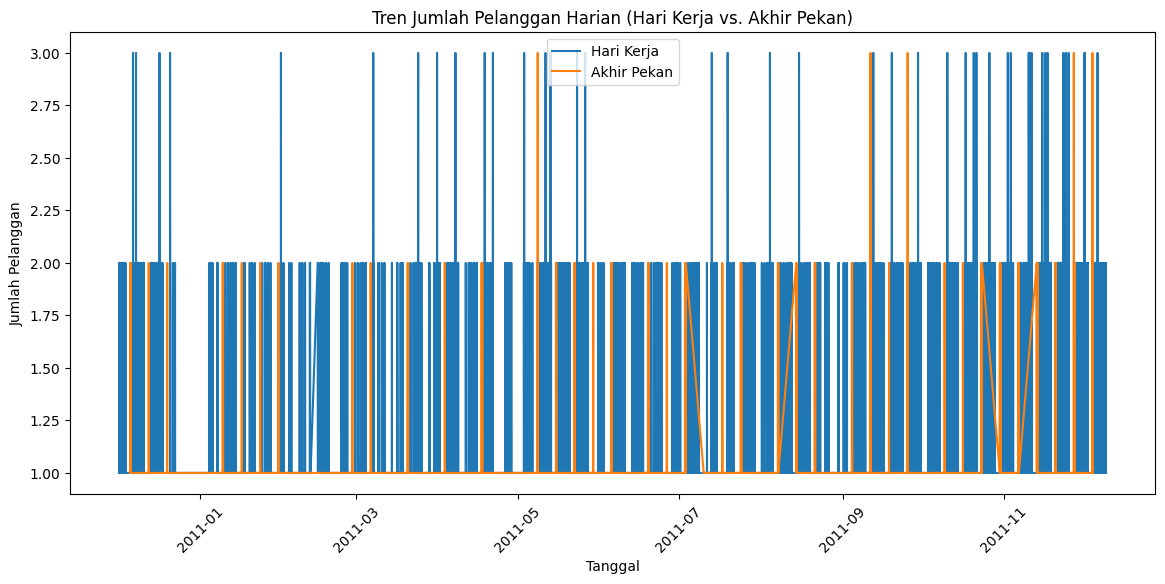

In [ ]:
# Grafik jumlah pelanggan harian untuk hari kerja
plt.figure(figsize=(14, 6))
sns.lineplot(x='InvoiceDate', y='CustomerID', data=daily_customer_counts[daily_customer_counts['DayType'] == 'Weekday'], label='Hari Kerja')

# Grafik jumlah pelanggan harian untuk akhir pekan
sns.lineplot(x='InvoiceDate', y='CustomerID', data=daily_customer_counts[daily_customer_counts['DayType'] == 'Weekend'], label='Akhir Pekan')

plt.title('Tren Jumlah Pelanggan Harian (Hari Kerja vs. Akhir Pekan)')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Note : Diminggu keberapa pembelian dengan jumlah customer terbanyak

In [ ]:
# Hitung jumlah pelanggan mingguan
weekly_customer_counts = df.groupby(by=pd.Grouper(key="InvoiceDate", freq="W"))["CustomerID"].nunique()

# Temukan minggu dengan jumlah pelanggan terbanyak
max_weekly_customer_count = weekly_customer_counts.idxmax()

# Mendapatkan informasi minggu keberapa dari tanggal
week_number = max_weekly_customer_count.week

print("Waktu dengan Jumlah Pelanggan Terbanyak Mingguan:")
print("Minggu ke-{}: {}".format(week_number, max_weekly_customer_count))


Waktu dengan Jumlah Pelanggan Terbanyak Mingguan:
Minggu ke-46: 2011-11-20 00:00:00


Note : Dari Negara mana customer terbanyak yang membeli

In [ ]:
# Hitung total pembelian per customer
customer_total_amount = df.groupby(['CustomerID', 'Country'])['TotalAmount'].sum().reset_index()

# Temukan customer dengan total pembelian terbanyak di negara tertentu (misalnya, UK)
top_customer_info = customer_total_amount[customer_total_amount['Country'] == 'United Kingdom'].nlargest(1, 'TotalAmount')

print("Customer dengan Total Pembelian Terbanyak di UK:")
print("Customer ID:", top_customer_info['CustomerID'].values[0])
print("Negara:", top_customer_info['Country'].values[0])
print("Total Pembelian:", top_customer_info['TotalAmount'].values[0])

Customer dengan Total Pembelian Terbanyak di UK:
Customer ID: 18102.0
Negara: United Kingdom
Total Pembelian: 259657.3


Note : Produk Terlaris

In [ ]:
# Hitung total kuantitas produk berdasarkan deskripsi
product_quantities = df.groupby('Description')['Quantity'].sum().reset_index()

# Pilih lima produk dengan kuantitas terbanyak
top_products = product_quantities.nlargest(5, 'Quantity')

# Tampilkan hasil
print("Top 5 Produk dengan Kuantitas Terbanyak:")
print(top_products)

Top 5 Produk dengan Kuantitas Terbanyak:
                             Description  Quantity
2319         PAPER CRAFT , LITTLE BIRDIE     80995
1992      MEDIUM CERAMIC TOP STORAGE JAR     77916
3786   WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
1762             JUMBO BAG RED RETROSPOT     46181
3698  WHITE HANGING HEART T-LIGHT HOLDER     36725


<ipython-input-64-ca44669e4afc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quantity', y='Description', data=top_products, palette='viridis')


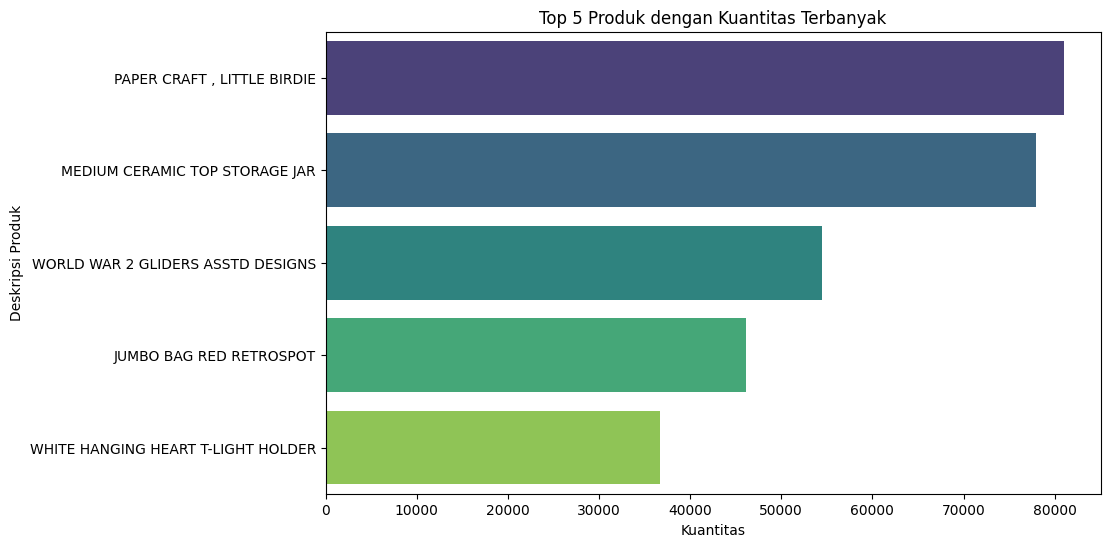

In [ ]:
# Visualisasi top 5 produk dengan kuantitas terbanyak
plt.figure(figsize=(10, 6))
sns.barplot(x='Quantity', y='Description', data=top_products, palette='viridis')
plt.title('Top 5 Produk dengan Kuantitas Terbanyak')
plt.xlabel('Kuantitas')
plt.ylabel('Deskripsi Produk')
plt.show()

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

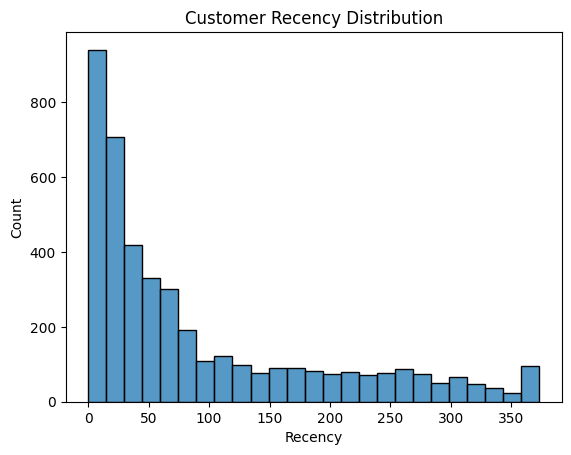

In [ ]:
# Recency histogram plot
_ = plt.title('Customer Recency Distribution')
_ = sns.histplot(recency)
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')

frequency.head()

CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

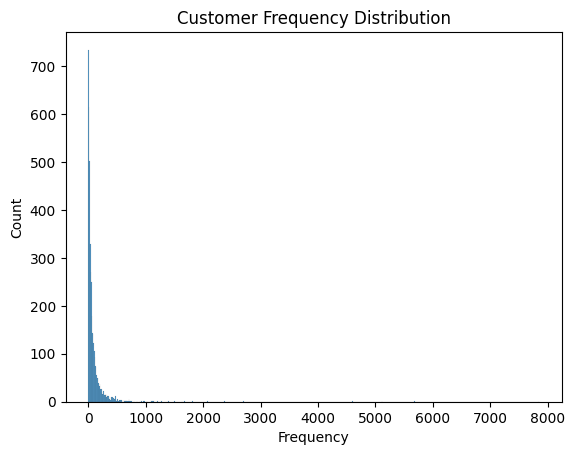

In [ ]:
# Frequency histogram plot
_ = plt.title('Customer Frequency Distribution')
_ = sns.histplot(frequency)
plt.show()

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')

monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary, dtype: float64

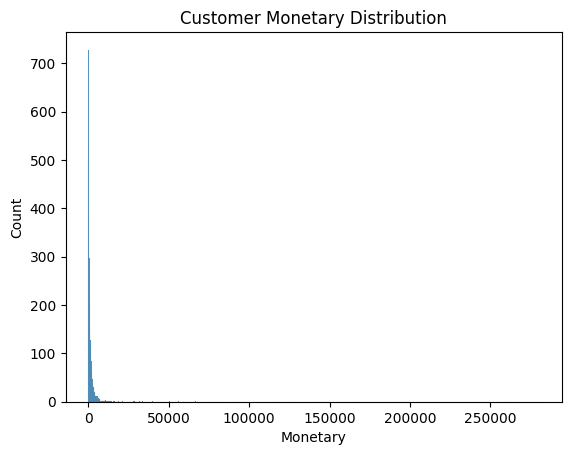

In [ ]:
# Monetary histogram plot
_ = plt.title('Customer Monetary Distribution')
_ = sns.histplot(monetary)
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = df.groupby(['CustomerID', 'Country_isUK']).size().reset_index().drop(0, axis = 1)

# Merge the data
df_new = country \
    .merge(recency, on = 'CustomerID') \
    .merge(frequency, on = 'CustomerID') \
    .merge(monetary, on = 'CustomerID')

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')

df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable
#Label Encoding boleh(Karena Value nya hanya 2. jika value nya lebih dari 2 lebih baik One Hot)
#One Hot Encoding akan lebih sulit saat di deploy
df_new = pd.get_dummies(df_new, columns=['Country_isUK'], drop_first=True)
df_new = df_new.rename(columns = {'Country_isUK_UK': 'Country_UK'})

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

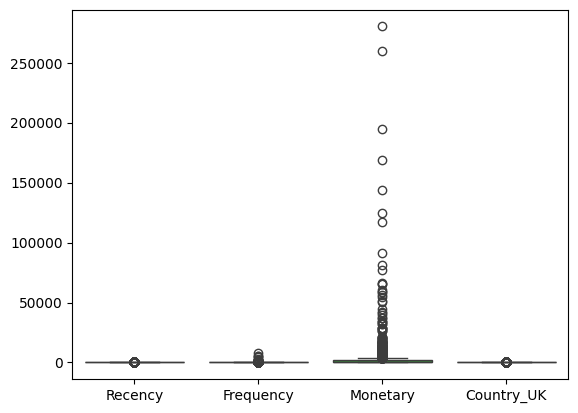

In [ ]:
_ = sns.boxplot(data = df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(df_scaled, columns = df_new.columns, index = df_new.index)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


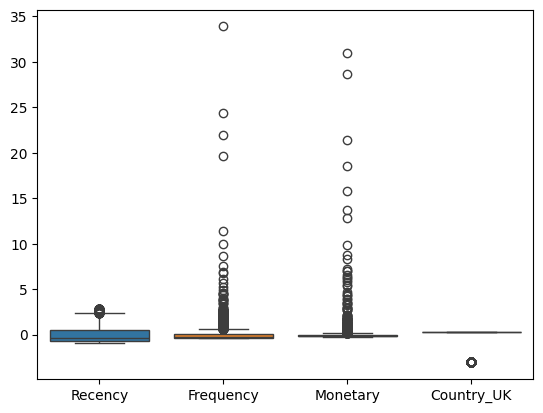

In [ ]:
# Plot scaled data
_ = sns.boxplot(data = df_scaled)
plt.show()

## Modeling

In [ ]:
# Modeling
#Menentukan K terbaik (Banyak nya cluster yang terbaik/ Mau dibagi menjadi beberapa kelompok?)
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = [] #Scroring untuk Model Clusturing terbaik

#Loop untuk looping K untuk dites ke silhoutte score untuk mencari skor terbaik
for k in possible_k:
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(df_scaled)

    silhouette.append(silhouette_score(X = df_scaled, labels = kmeans.labels_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

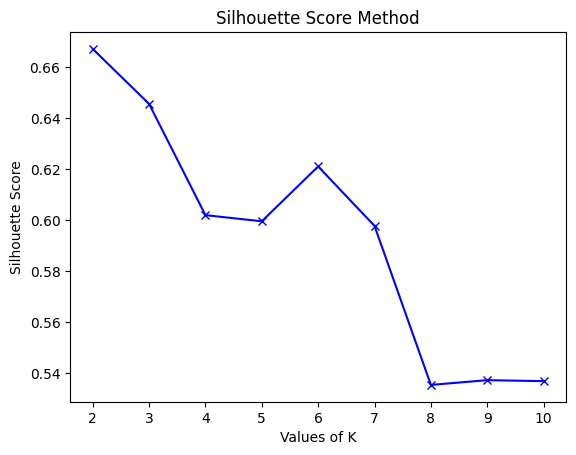

In [ ]:
# Plot the score
plt.plot(possible_k, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

Using silhouette score, the best K is either 2, 3 or 6

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


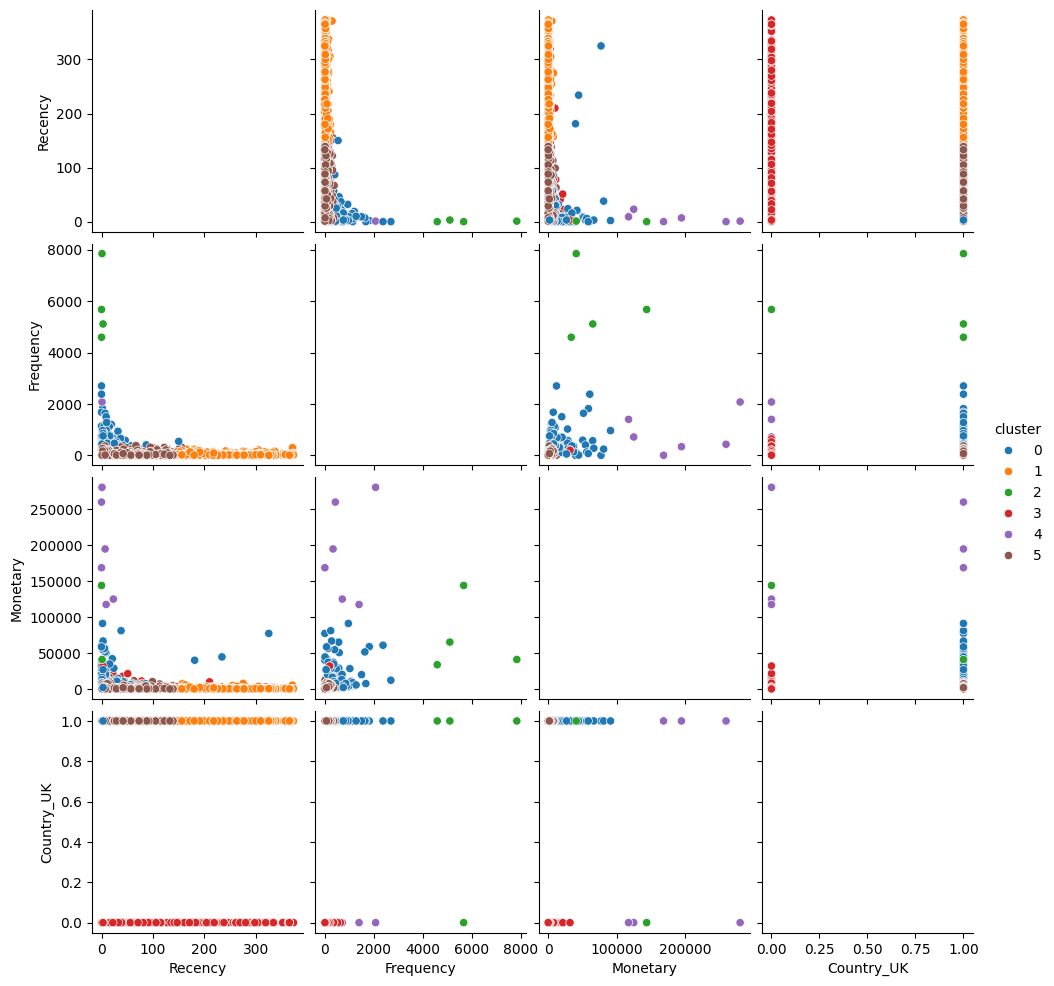

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state = 123).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

_ = sns.pairplot(data = df_result_kmeans, hue = 'cluster', diag_kind = 'None', palette = 'tab10')
plt.show()

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
df_result_kmeans \
    .drop("Country_UK", axis = 1) \
    .groupby('cluster') \
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max']) \
    .transpose()

cluster                      0            1              2             3  \
Recency   mean       15.234973   246.776618       1.000000     95.405797   
          std        35.305176    65.636727       1.414214    104.638705   
          min         0.000000   143.000000       0.000000      0.000000   
          q25         2.000000   189.000000       0.000000     18.000000   
          median      6.000000   242.000000       0.500000     52.000000   
          q75        16.000000   296.000000       1.500000    136.500000   
          max       325.000000   373.000000       3.000000    373.000000   
Frequency mean      535.360656    27.689979    5807.000000     81.396135   
          std       358.078267    32.176026    1429.730044     96.304061   
          min         1.000000     1.000000    4595.000000      1.000000   
          q25       367.000000     8.250000    4982.000000     21.250000   
          median    450.000000    18.000000    5393.000000     45.000000   
          q75       589.500000    33.000000    6218.000000    101.000000   
          max      2700.000000   297.000000    7847.000000    638.000000   
Monetary  mean    13085.065738   450.793070   70925.287500   2262.538913   
          std     16313.461152   610.367153   50424.336433   3479.689136   
          min      1093.650000     3.750000   33719.730000     51.560000   
          q25      4014.945000   163.225000   39173.610000    459.650000   
          median   6923.130000   305.515000   53078.180000   1025.700000   
          q75     13213.210000   505.542500   84829.857500   2659.962500   
          max     91062.380000  7832.470000  143825.060000  31906.820000   

cluster                       4             5  
Recency   mean         6.666667     42.676884  
          std          8.869423     36.313016  
          min          0.000000      0.000000  
          q25          0.250000     14.000000  
          median       4.000000     31.000000  
          q75          8.500000     64.000000  
          max         23.000000    155.000000  
Frequency mean       826.833333     76.270826  
          std        771.620481     74.030983  
          min          3.000000      1.000000  
          q25        360.500000     22.000000  
          median     572.500000     51.000000  
          q75       1228.500000    107.000000  
          max       2076.000000    385.000000  
Monetary  mean    190863.461667   1341.293935  
          std      67791.993010   1592.871914  
          min     117379.630000      6.200000  
          q25     135804.022500    371.700000  
          median  181511.645000    795.120000  
          q75     243380.672500   1720.300000  
          max     280206.020000  17654.540000

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1              183
1        1              958
2        0                1
         1                3
3        0              414
4        0                3
         1                3
5        1             2773
Name: Recency, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?